### Inference

PDE: $$3y''(t) + 2y'(t) + y(t) = -2 \sqrt{2} \:sin\left( x + \frac{\pi}{4} \right)$$
<br>
Boundary condition: $$y(0) = 1, y'(0) = 0$$ 
<br>
Domain: $t > 0$<br>

Solution: $y(t) = cos(t)$

### DNN

In [1]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN

In [2]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, t_tr, y_tr, y_t_tr, t_f, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"t_train shape: {t_tr.shape}")
            print(f"t_f shape: {t_f.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
        
        self.t_tr = torch.tensor(t_tr, requires_grad=True).float().to(self.device) # t=0
        self.y_tr = torch.tensor(y_tr).float().to(self.device) # y(0) = 1
        self.y_t_tr = torch.tensor(y_t_tr).float().to(self.device) #y(0) = 0
        self.t_f = torch.tensor(t_f, requires_grad=True).float().to(self.device) #collocation points
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )

        self.iter = 1
        
    def net_y_y_t(self,t): #get y(t) and y'(t) for a t; a forward pass through the PINN
        y = self.net(t)
        y_t = torch.autograd.grad( #first partial derivative with respect to t
            y, t, 
            grad_outputs=torch.ones_like(y),
            retain_graph=True,
            create_graph=True
        )[0]
        return y, y_t

    
    def net_f(self, t): #get f = 3* y_tt + 2 * y_t + y + 2 * sqrt(2) * sin(t + pi / 4)
        
        y, y_t = self.net_y_y_t(t)
        
        y_tt = torch.autograd.grad( #second partial derivative with respect to t
            y_t, t, 
            grad_outputs=torch.ones_like(y_t),
            retain_graph=True,
            create_graph=True
        )[0]
        f = 3 * y_tt + 2 * y_t + y + 2 * np.sqrt(2) * torch.sin(t + np.pi / 4)
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred, y_t_pred = self.net_y_y_t(self.t_tr) 
        f_pred = self.net_f(self.t_f) 
        loss_y = torch.mean((self.y_tr - y_pred) ** 2) + torch.mean((self.y_t_tr - y_t_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2) 
        
        loss = loss_y + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_y: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_y.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, t):
        
        t = torch.tensor(t, requires_grad=True).float().to(self.device)
        
        self.net.eval()
        
        y, y_t = self.net_y_y_t(t) 
        f = self.net_f(t)
        
        y = y.detach().cpu().numpy()
        y_t = y_t.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return y, y_t, f

### Data generation

In [3]:
import numpy as np
torch.manual_seed(0)

def exact_y(t):
    return np.cos(t)

def exact_de(t): #membre de droite equadiff
    return -2 * np.sqrt(2) * np.sin (t + np.pi / 4)

# generate colocation points
import random
random.seed(1)

upper_bound = 12 * np.pi
lower_bound = 0

N_f = 10000
t_f = [random.uniform(lower_bound,upper_bound) for _ in range(N_f)] # a list
t_f = np.array([t_f]).T  #an array


y_true = exact_y(t_f).reshape(-1,1) #exact y(t)
de_true = exact_de(t_f) #exact membre de droit de l'equa diff

#boundary conditions
N_u = 1
t_tr = np.array([0.0]).reshape(-1,1)
y_tr = 1
y_t_tr = 0

### Create and train

In [4]:
%%time

nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([1]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

model = PINN(layers, t_tr, y_tr, y_t_tr, t_f, tol=1e-5, hs=50)

model.train()

device used: cuda:0
t_train shape: (1, 1)
t_f shape: (10000, 1)
Iter 100, Loss: 2.93499e+00, Loss_y: 1.95072e-04, Loss_f: 2.93479e+00
Iter 200, Loss: 2.31222e+00, Loss_y: 1.02931e-04, Loss_f: 2.31212e+00
Iter 300, Loss: 1.48012e+00, Loss_y: 2.09313e-03, Loss_f: 1.47802e+00
Iter 400, Loss: 1.05064e+00, Loss_y: 3.26917e-04, Loss_f: 1.05032e+00
Iter 500, Loss: 9.34360e-01, Loss_y: 5.17600e-04, Loss_f: 9.33843e-01
Iter 600, Loss: 8.53484e-01, Loss_y: 5.85021e-04, Loss_f: 8.52899e-01
Iter 700, Loss: 7.80940e-01, Loss_y: 3.32096e-05, Loss_f: 7.80907e-01
Iter 800, Loss: 6.73942e-01, Loss_y: 1.44939e-04, Loss_f: 6.73797e-01
Iter 900, Loss: 4.40135e-01, Loss_y: 2.14705e-04, Loss_f: 4.39920e-01
Iter 1000, Loss: 3.67162e-01, Loss_y: 2.66053e-04, Loss_f: 3.66896e-01
Iter 1100, Loss: 2.37462e-01, Loss_y: 7.19877e-04, Loss_f: 2.36742e-01
Iter 1200, Loss: 1.82097e-01, Loss_y: 1.11203e-04, Loss_f: 1.81986e-01
Iter 1300, Loss: 1.69467e-01, Loss_y: 1.04341e-04, Loss_f: 1.69363e-01
Iter 1400, Loss: 1.583

### Evaluate

In [5]:
def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

y_pred_tr, y_t_pred_tr, _ = model.predict(t_tr)

mse_y_tr = mse(y_pred_tr, y_tr)
mse_y_t_tr = mse(y_t_pred_tr, y_t_tr)


y_pred, y_t_pred, f_pred_tr = model.predict(t_f)
mse_f_tr = mse(f_pred_tr, np.zeros(f_pred_tr.shape))

print(f'MSE Error y(t): %e' % (mse_y_tr))
print(f'MSE Error y''(t): %e' % (mse_y_t_tr))
print(f'MSE Error f: %e' % (mse_f_tr)) 

MSE Error y(t): 6.106872e-08
MSE Error y(t): 5.537523e-09
MSE Error f: 4.289637e-04


### Plot Train Perf

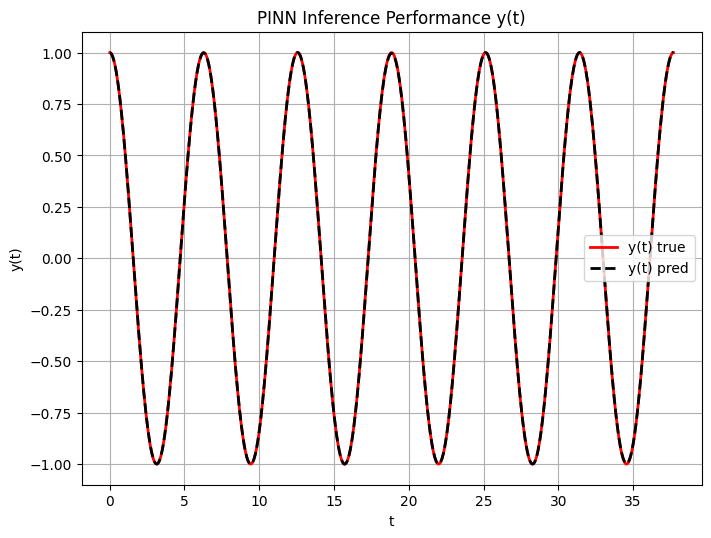

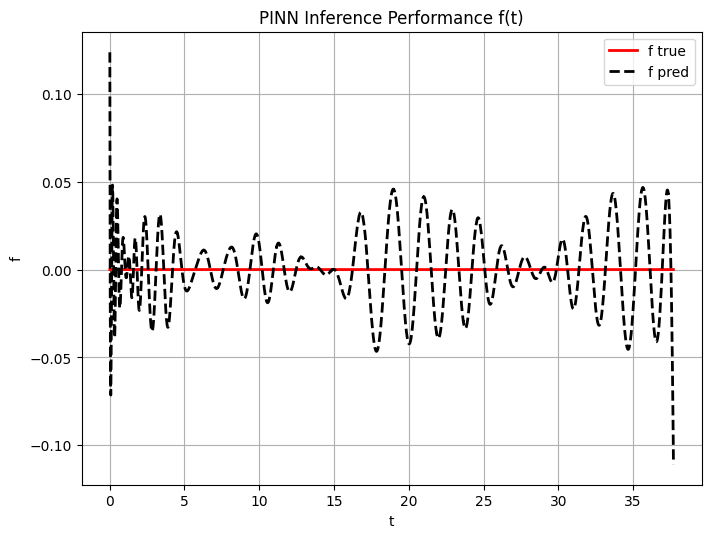

'\ntogether = np.hstack([t_f,de_true])\ntogether = together[together[:, 0].argsort()]\n\ntogether1 = np.hstack([t_f,f_pred_tr + de_true])\ntogether1 = together1[together1[:, 0].argsort()]\n\nplt.figure(figsize=(8, 6), dpi=100)\nplt.plot(together[:,0],together[:,1], color="red", linewidth=2, label=\'DE true\')\nplt.plot(together1[:,0],together1[:,1], color="black",linestyle=\'--\', linewidth=2, label=\'DE pred\')\nplt.legend()\nplt.grid()\nplt.xlabel("t")\nplt.ylabel("DE")\nplt.title("PINN Inference Performance DE")\nplt.show()'

In [6]:
import matplotlib.pyplot as plt

together = np.hstack([t_f,y_true])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_f,y_pred])
together1 = together1[together1[:, 0].argsort()]

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='y(t) true')
plt.plot(together1[:,0], together1[:,1],color="black",linestyle='--', linewidth=2, label='y(t) pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("PINN Inference Performance y(t)")
plt.show()



together = np.hstack([t_f,np.zeros(t_f.shape)])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_f,f_pred_tr])
together1 = together1[together1[:, 0].argsort()]

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='f true')
plt.plot(together1[:,0],together1[:,1], color="black",linestyle='--', linewidth=2, label='f pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("f")
plt.title("PINN Inference Performance f(t)")
plt.show()


"""
together = np.hstack([t_f,de_true])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_f,f_pred_tr + de_true])
together1 = together1[together1[:, 0].argsort()]

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='DE true')
plt.plot(together1[:,0],together1[:,1], color="black",linestyle='--', linewidth=2, label='DE pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("DE")
plt.title("PINN Inference Performance DE")
plt.show()"""

Plot Extrapolation 

MSE Error y(t): 5.043556e+01
MSE Error f: 5.868457e+01


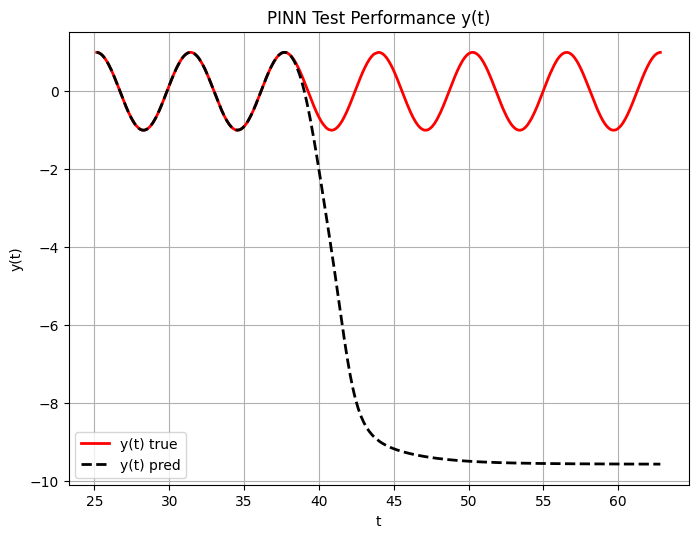

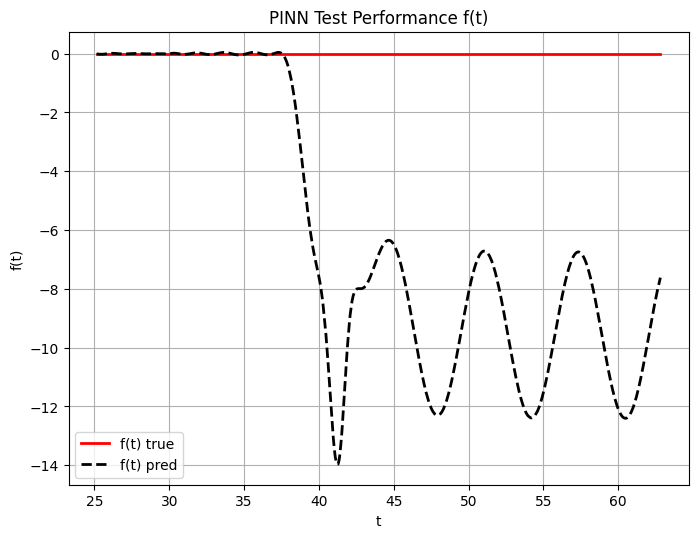

In [7]:
N_ex = 1000
lower_bound_ex = 8 * np.pi
upper_bound_ex = 20 * np.pi
t_ex = [random.uniform(lower_bound_ex,upper_bound_ex) for _ in range(N_ex)] # a list
t_ex = np.array([t_ex]).T  #an array

y_ex_true = exact_y(t_ex)

y_pred_te, _, f_ex = model.predict(t_ex)


print(f'MSE Error y(t): %e' % (mse(y_pred_te, y_ex_true)))
print(f'MSE Error f: %e' % (mse(f_ex, np.zeros(f_ex.shape)))) 


together = np.hstack([t_ex,y_ex_true])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_ex,y_pred_te])
together1 = together1[together1[:, 0].argsort()]

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='y(t) true')
plt.plot(together1[:,0], together1[:,1],color="black",linestyle='--', linewidth=2, label='y(t) pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("PINN Test Performance y(t)")
plt.show()



together = np.hstack([t_ex,np.zeros(t_ex.shape)])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_ex,f_ex])
together1 = together1[together1[:, 0].argsort()]

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='f(t) true')
plt.plot(together1[:,0], together1[:,1],color="black",linestyle='--', linewidth=2, label='f(t) pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("PINN Test Performance f(t)")
plt.show()